In [63]:
## todo
## create and plot rolling params, to understand weight of contribution and how this evolves
## Rolling correlations

In [17]:
import os
from datetime import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from BlueOcean import DataAccessApi
import statsmodels.formula.api as sm
from statsmodels.regression.rolling import RollingOLS

from ag_datagenic_rest_client import DataGenic
d = DataGenic.create_from_environment()

import eikon as ek
ek.set_app_key('f1835ae44d1e47d1aeaf3d5d795921bd6e044df9')

from tshistory.api import timeseries
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')

def bo_get_data(query):
    data = DataAccessApi.GetDataframe(query)
    return data

In [18]:
# # vlsfo = d.get_curve('model://PI_OIL_PROD_HEA/PI.FO05HDHV.BFOBARA.USD.MT.C')
# vlsfo = d.get_curve('model://PI_OIL_PROD_HEA/PI.MARINEFO.BFOBRDAM.USD.MT.C')
# mgo = d.get_curve('model://PI_OIL_PROD_MID/PI.GO01.CCIFNWE.USD.MT.C/CURVE')
# df = pd.concat([mgo.PRICE,vlsfo.PRICE], axis=1)
# df.columns = ['mgo','vlsfo']
# df.to_csv('bunkers_fwd.csv')

In [19]:
def get_eikon(tickers, start_date):
    fields='CLOSE'
    fn = lambda x: ek.get_timeseries(x[1], start_date=start_date, interval='daily',fields=fields)[fields].rename(x[0])
    return pd.concat(map(fn, tickers.items()), axis=1).resample('D').median().dropna(axis=0)

In [20]:
tickers = {
    'brent':'AAYES00',
    # 'brent': 'AABRM24',
    'spread':'BFS0203',
    'sp500':'ESc1',
    'dxy':'.DXY',
    'ulsd_crack':'AAYTY00',
    'ttf':'TRNLTTFMc1',
    'metals':'.BCOMIN',
    'inflation':'USINF5YF5Y=R'
}
# add 'dxy':'.DXY',

In [21]:
plt.style.use('ggplot')

In [22]:
data = get_eikon(tickers, start_date='2017-01-01')

In [23]:
# change regression period with date
def decompose_flat_price(data, freq, year):
    # df = get_eikon(tickers, start_date=year).fillna('ffill')
    df = data.loc[year:].fillna('ffill')
    endog = df.astype(float).resample(freq).last().diff()
    vars = ' + '.join(df.columns[1:].to_list())
    model = sm.ols(f'brent ~ {vars}', data=endog)
    results = model.fit()
    print(results.rsquared)
    weightings = pd.DataFrame([results.params[1:].values.T], index=endog.index, columns=endog.columns[1:])
    contribution = weightings.mul(endog.iloc[:, 1:])
    view = contribution[year:].dropna()
    # plotting charts
    fig, ax = plt.subplots(nrows=3)
    view.plot.bar(stacked=True, ax=ax[0], figsize=(10,10), ylabel='$/bbl', title='Decomposition of ICE Brent M01 daily moves', legend=False)
    view.cumsum().plot.bar(stacked=True, ax=ax[1], figsize=(10,10), ylabel='$/bbl').legend(loc='upper left')
    view.sum(axis=1).cumsum().plot(ax=ax[2], label='implied change', legend=True, ylabel='$/bbl').legend(loc='upper left')
    endog.brent[year:].dropna().cumsum().plot(ax=ax[2], label='actual change', ylabel='$/bbl', legend=True, figsize=(10,10))
    ax[0].set_xticklabels([])
    ax[0].set_xlabel('')
    ax[1].set_title(label = 'Cumulative changes', fontsize=11)
    ax[1].set_xticklabels([])
    ax[1].set_xlabel('')
    return plt.show()

In [24]:
delta = dt(2023,2,10)-dt(2023,1,1)
start = dt.today() - delta

In [25]:
start.date()

datetime.date(2023, 5, 27)

<Axes: xlabel='Date', ylabel='$/bbl'>

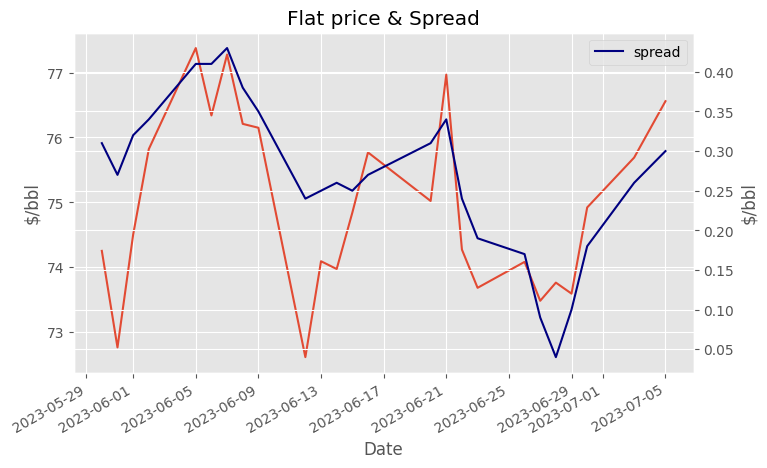

In [26]:
fig, ax = plt.subplots(ncols=1)
data.brent.loc[start:].plot(title='Flat price & Spread', ylabel='$/bbl', ax=ax, figsize=(10,5))
ax2 = ax.twinx()
data.spread.loc[start:].plot(ylabel='$/bbl', ax=ax2, figsize=(8,5), color='navy', legend=True)

0.7297447236818937


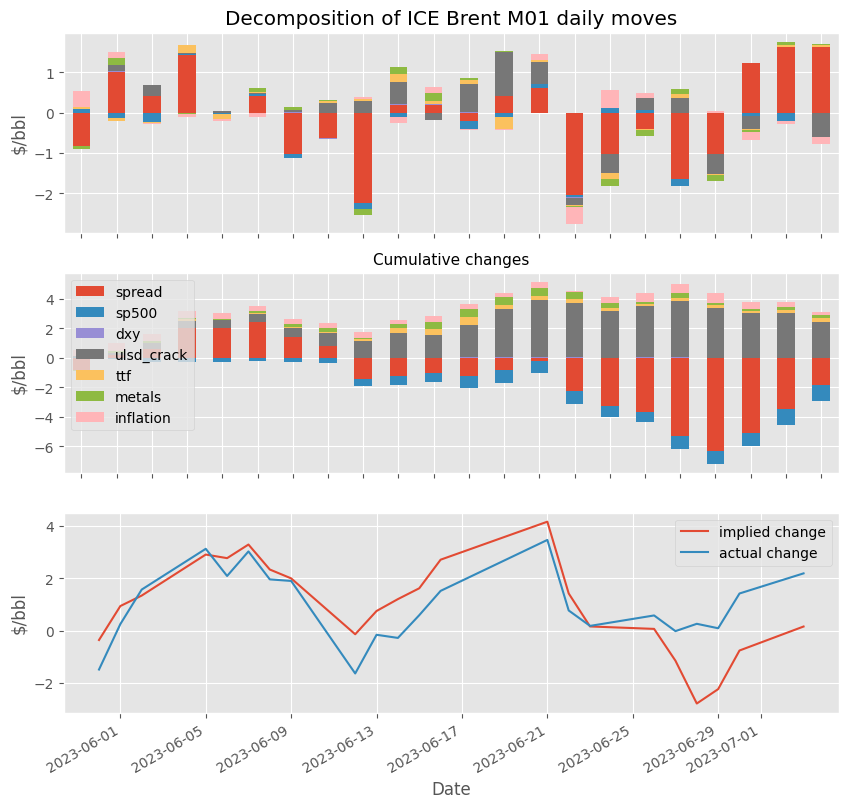

In [28]:
decompose_flat_price(data,'B',start)

### Rolling regression

In [12]:
def rolling_params(data, freq, year, window):
    df = data.loc[year:].fillna('ffill').resample(freq).last().diff().dropna()
    endog = df.brent.to_numpy(dtype='float')
    exog = df[df.columns[1:]].to_numpy(dtype='float')
    mod = RollingOLS(endog, exog, window=window)
    result = mod.fit()
    rolling_params = pd.DataFrame(result.params)
    rolling_params.columns = df.columns[1:]
    rolling_params.index = df.index
    rolling_params.plot(subplots=True, figsize=(8,8))
    plt.title(label=F'Contribution of factors (rolling {window} day regression)', y=8.5)
    return 

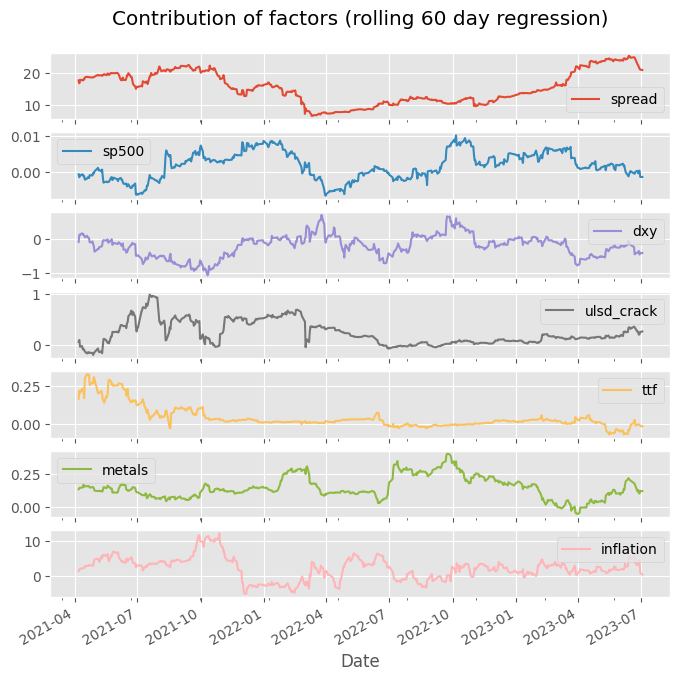

In [13]:
rolling_params(data, 'B', '2021', 60)

### Rolling correlations

In [14]:
def rolling_correlation(data, window, year):
    df = data.copy()
    rolling_corr = df.brent.rolling(window).corr(df[df.columns[1:]])
    rolling_corr.loc[year:].plot(subplots=True, figsize=(8,8))
    plt.title(label=F'Rolling {int(window/5)} week correlation', y=8.5)

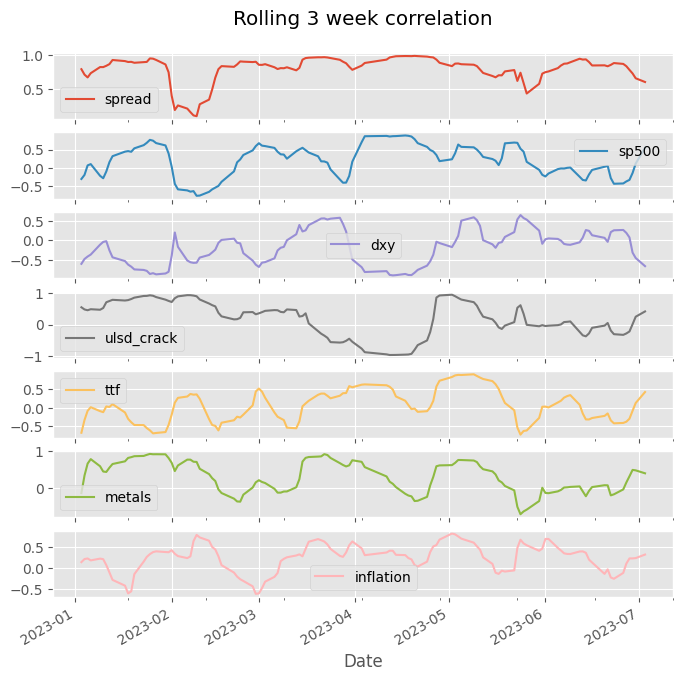

In [15]:
rolling_correlation(data, 15,'2023')

### OOW regressions

In [18]:
oow = tsa.get('crude.kpler.oil_on_water.kbd.daily')
flatty = d.get_time_series('model://ICE_BRENT/EU.OIL.NSEA.ICE.BRENT.FUT.M01', from_date=dt(2016,1,1), to_date=dt.today())

<Axes: >

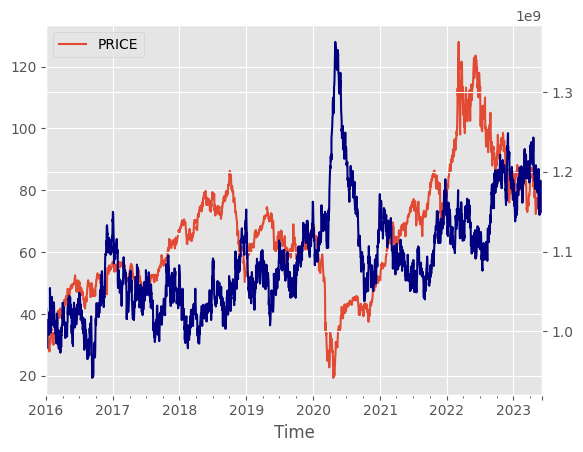

In [21]:
fig, ax = plt.subplots()
flatty.plot(ax=ax)
ax2 = ax.twinx()
oow.plot(ax=ax2,color='navy')

<Axes: >

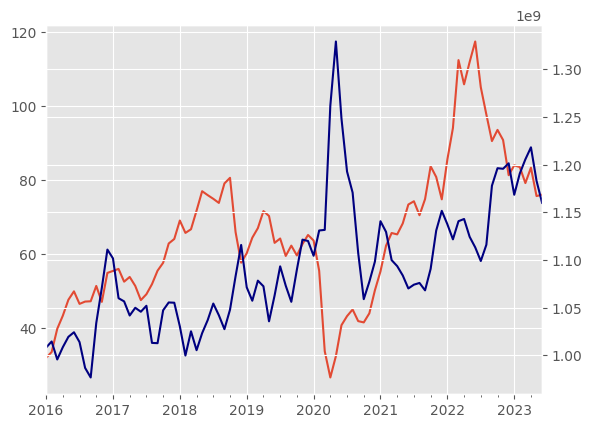

In [45]:
df = pd.concat([flatty, oow], axis=1).dropna()
df.columns = ['brent', 'oow']
# df = df.rolling(14).mean()
df = df.resample('MS').mean()
endog = df.diff()
fig, ax = plt.subplots()
df.brent.plot(ax=ax)
ax2 = ax.twinx()
df.oow.plot(ax=ax2,color='navy')

In [49]:
model = sm.ols(formula= f'brent ~ oow', data=df)
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  brent   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.3519
Date:                Mon, 12 Jun 2023   Prob (F-statistic):              0.556
Time:                        18:30:11   Log-Likelihood:                -240.12
No. Observations:                  54   AIC:                             484.2
Df Residuals:                      52   BIC:                             488.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    103.0613     54.973      1.875      0.066      -7.250     213.372
oow        -2.886e-08   4.86e-08     -0.593      0.556   -1.26e-07    6.88e-08
==============================================================================
Omnibus:                        0.962   Durbin-Watson:                   0.098
Prob(Omnibus):                  0.618   Jarque-Bera (JB):                1.037
Skew:                           0.258   Prob(JB):                        0.595
Kurtosis:                       2.559   Cond. No.                     2.17e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""